In [6]:
import pickle
from  matplotlib.pyplot import imshow
import os
import numpy as np

In [7]:
dataset_directory = "dataset"    
dataset = pickle.load( open( os.path.join(dataset_directory, "datasetk3.p"), "rb" ) )


In [8]:
dataset.keys()

dict_keys(['input', 'targets', 'mean'])

(100000, 3, 33, 33)

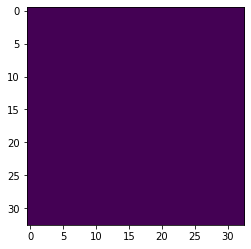

In [9]:
imshow(dataset['input'][39040, 0])
dataset['input'].shape

In [10]:
# max([np.sqrt(a**2 + b**2) for a,b in dataset['targets']])
print(dataset['targets'].shape)
dataset['targets'][39040]

(100000, 2)


array([0., 0.])

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

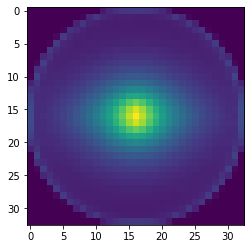

In [9]:
imshow(dataset['mean'][0])
dataset['mean'][0]

In [1]:
import os
import sys 
# sys.path.append(os.getcwd() + "python")
sys.path.append(os.getcwd() + "/python/lib/python")

# Pipeline

In [1]:
# Wojciech Golaszewski

%matplotlib inline
%load_ext autoreload
%autoreload 2

%run implementations.py

from IPython.core.debugger import set_trace
from sklearn.decomposition import PCA

found resources


## Helpers


In [2]:
def gen_ellipsoid_point_cloud(a,b,c,n):
    angles = np.random.uniform(0,np.pi,(n, 2)) * [1,2]
    surface_points = np.array([
        [a * np.sin(theta) * np.cos(gamma),
         b * np.sin(theta) * np.sin(gamma),
         c * cos(theta)]
        for theta, gamma in angles
    ])
#     distances = np.random.uniform(0,1,(n, 1))
#     point_cloud = np.array(surface_points * distances)
    return surface_points

def get_pca_axis(points):
    pca = PCA(n_components=3)
    pca.fit(points)
    return pca.components_.T
    
def test_pca_rect():
    rect = np.random.uniform(-0.5,0.5,(1000, 3)) * [1,2,5] * 0.6
    r = Rotation.random(random_state=1234).as_matrix()
    rect = (r @ rect.T).T 
    pcar = get_pca_axis(rect)
    axr = rotate_trimesh(axis_mesh.copy(), pcar)


    pymesh = pyrender.Mesh.from_points(rect)
    axmesh = pyrender.Mesh.from_trimesh(axis_mesh)
    axrmesh = pyrender.Mesh.from_trimesh(axr)
    run_gui_pyrmesh([pymesh, axrmesh], point_size=5)
    
def test_pca_ellipsoid():
    ell = gen_ellipsoid_point_cloud(3,5,7, 1000) * 0.2
    r = Rotation.random(random_state=1234).as_matrix()

    ell = (r @ ell.T).T 

    space = 3

    ellr = (r @ ell.T).T + [space, 0, 0]
    axis_meshr = axis_mesh.copy() \
        .apply_rotation(r).apply_translation([space,0,0])

    pca_comp = get_pca_axis(ell)
    ell_t = (pca_comp.T @ ell.T).T + [space, 0, 0]
#     axis_meshrpca = axis_mesh.copy() \
#         .apply_rotation(pca_comp).apply_translation([space, 0,0])
    axis_mesh_tran = axis_mesh.copy().apply_translation([space,0,0])
    colors = np.array([1,0.7,0.1] * len(ell)).reshape(ell.shape)


    run_gui_pyrmesh([
        pyrender.Mesh.from_points(ell),
        pyrender.Mesh.from_trimesh(axis_mesh),
    #     pyrender.Mesh.from_points(ellr),
    #     pyrender.Mesh.from_trimesh(axis_meshr),
        pyrender.Mesh.from_points(ell_t, colors=colors),
        pyrender.Mesh.from_trimesh(axis_mesh_tran),
    ], point_size=2)

## Visualisers

In [3]:
def visualise_valid_points(points, valid_point_indices):
    colors = np.ones_like(points)
    colors[valid_point_indices] = [1, 0.3,0.1]
    
    axis_mesh = get_axis_trimesh(thickness = 1)
    pymesh = pyrender.Mesh.from_points(points, colors=colors)
    axmesh = pyrender.Mesh.from_trimesh(axis_mesh)
    run_gui_pyrmesh([pymesh, axmesh], point_size=5)

## Code

In [4]:
def load_point_cloud(file_path):
    lines  = open(file_path).read().split("\n")[:-1]
    point_cloud = np.array([
        [float(x) for x in line.split(" ")[:3]]
        for line in lines
    ])
    return point_cloud

def get_points_close_to_origin(point_cloud, max_dst):
    return np.array([
        i for i, point in enumerate(point_cloud)
        if np.linalg.norm(point) < max_dst**0.5])

def get_pca_axis_3d(point_cloud):
    pca = PCA(n_components=3)
    pca.fit(point_cloud)
    return pca.components_

def rotate_point_cloud(point_cloud, rot_matrix):
    return np.array((rot_matrix @ point_cloud.T).T)

In [8]:
def generate_accums_for_point_cloud(
    point_cloud, 
    neighbourhood_sizes):
    
    MAX_DIST_TO_ORIGIN = 0.02
    
    # Number of hypthesis to draw     
    T = 1000
    
    # Accum size
    A = 33
    
    # nth furthest point to take into account in density variation trick
    DVth = 5
    
    points_close_to_origin_indices = get_points_close_to_origin(point_cloud, MAX_DIST_TO_ORIGIN)

#     visualise_valid_points(point_cloud, points_close_to_origin_indices)

    kd_tree = KDTree(point_cloud)
    K_max = neighbourhood_sizes[-1]
    
    distances, _ = kd_tree.query(point_cloud, k = DVth + 1)
    aniso_probabilities = np.array(distances[:, -1])
    
    for point_index in points_close_to_origin_indices:
        point = point_cloud[point_index]
        
        # +1 to compensate for the fact that the first result is the point itself 
        _, indices = kd_tree.query([point], k=K_max + 1)
        indices = indices[0,1:-1]
        max_neighbourhod = point_cloud[indices]
    
        pca_rot_3d = get_pca_axis_3d(max_neighbourhod)
        # Aligns z-axis on the smallest Principal Component
        max_neighbourhod = rotate_point_cloud(max_neighbourhod, pca_rot_3d)
        
        for k in neighbourhood_sizes:
            
            accumulator = np.zeros((33,33))   
            accum_normals = np.zeros((k, 3))
            
            nearest_neighbour_point_indices = indices[:k]
            
            local_aniso_prob = aniso_probabilities[nearest_neighbour_point_indices]
            local_aniso_prob /= np.sum(local_aniso_prob)
            
            for i in range(T):
                
                hypothesis_point_indices = nearest_neighbour_point_indices[
                    np.random.choice(k, 3, replace=False, p = local_aniso_prob)
                ]
                
                [a,b,c] = point_cloud[hypothesis_point_indices]

                vec_1 = b - a 
                vec_2 = c - a

                normal = np.cross(vec_1, vec_2)
                normal = normal / np.sum(normal)


                if np.dot(normal, [0,0,1]) < 0:
                    # reorient normal
                    normal = normal * -1
                


In [9]:
    point_cloud = load_point_cloud("3dmodels/model_256.xyz")

In [10]:
# default neighbourhood size
K = 100

# neighbourhood sizes for multiscale approach
Ks = [K//2, K, K*2]
Ks.sort()

generate_accums_for_point_cloud(point_cloud, Ks)

ValueError: 'a' and 'p' must have same size

In [14]:
a = np.sort([4, .25, 0.5, 1, 2])
np.array(a * 100, dtype="uint")

array([ 25,  50, 100, 200, 400], dtype=uint32)

In [79]:
K_max =  1000
kd_tree = KDTree(point_cloud)
close = get_points_close_to_origin(point_cloud, 0.02)
distances, indices = kd_tree.query([point_cloud[close[0]]], k=K_max)

In [129]:
distances, indices = kd_tree.query(point_cloud, k = 5 + 1)
probabilities = distances[:, -1]
probabilities = probabilities / np.sum(probabilities)
probabilities.shape

(5000,)

In [57]:
r = Rotation.random(random_state=1234).as_matrix()
r @ [0,2,3]

array([ 1.5385132 , -2.86752372, -1.55250921])